In [1]:
import torch
 
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import json
import copy

E:\anaconda\envs\data_mining\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

pd.set_option('display.min_rows',100)  
path = '..\..\dataset\data_xyz\provinceData\上海市.json' ##记得改
fr = open(path, 'r', encoding='utf-8')
json_info = fr.read()
fr.close()
data_dict = json.loads(json_info)
data = pd.DataFrame(data_dict['data'])
data = data[['confirmedIncr', 'dateId']]
data['dateId'] = data['dateId'].astype(str)
data['dateId'] = pd.to_datetime(data['dateId'], format='%Y%m%d')
data.index = data['dateId']
data = data.set_index('dateId', drop=True)
data_size = int(len(data)*0.7)
test_set = data[-data_size:]
train_set = data[:data_size]
test_set = data[-(len(data)-len(train_set)):]
temp =copy.deepcopy(test_set)
train_set.head()

,confirmedIncr
dateId,
2020-01-20,1
2020-01-21,8
2020-01-22,7
2020-01-23,4
2020-01-24,13


E:\anaconda\envs\data_mining\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


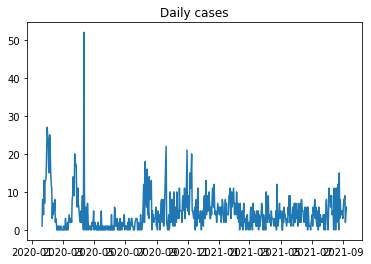

In [3]:
plt.plot(train_set)
plt.title("Daily cases");

In [4]:

scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

"""
print(train_set.values.shape)
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_set, axis=1))
 
train_data = scaler.transform(np.expand_dims(train_set, axis=1))
test_data = scaler.transform(np.expand_dims(test_set, axis=1))


"""


'\nprint(train_set.values.shape)\nscaler = MinMaxScaler()\nscaler = scaler.fit(np.expand_dims(train_set, axis=1))\n \ntrain_data = scaler.transform(np.expand_dims(train_set, axis=1))\ntest_data = scaler.transform(np.expand_dims(test_set, axis=1))\n\n\n'

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
 
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
 
    return np.array(xs), np.array(ys)
 
seq_length = 7
X_train, y_train = create_sequences(train_set, seq_length)
X_test, y_test = create_sequences(test_set, seq_length)
 
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
 
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [6]:
class CoronaVirusPredictor(nn.Module):
 
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
 
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
 
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )
 
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
 
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
 
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [7]:
def train_model(
      model, 
      train_data, 
      train_labels, 
      test_data=None, 
      test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')
 
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs =100
 
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
 
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
 
            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
 
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
 
    return model.eval(), train_hist, test_hist

In [8]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 8.03943157196045 test loss: 4.404657363891602
Epoch 10 train loss: 4.878168106079102 test loss: 4.750375270843506
Epoch 20 train loss: 4.78985595703125 test loss: 4.227008819580078
Epoch 30 train loss: 4.766040802001953 test loss: 4.454812049865723
Epoch 40 train loss: 4.743781566619873 test loss: 4.35930061340332
Epoch 50 train loss: 4.743126392364502 test loss: 4.355146408081055
Epoch 60 train loss: 4.741468906402588 test loss: 4.381479263305664
Epoch 70 train loss: 4.74247407913208 test loss: 4.3349151611328125
Epoch 80 train loss: 4.743897914886475 test loss: 4.33492374420166
Epoch 90 train loss: 4.731810092926025 test loss: 4.317407608032227


In [9]:
with torch.no_grad():
    i =0
    test_seq = X_test[i:i+1]
    
    preds = []
    
    for _ in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        i+=1
##        new_seq = test_seq.numpy().flatten()
##        new_seq = np.append(new_seq, [pred])
##        new_seq = new_seq[1:]
##       test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [10]:

true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()


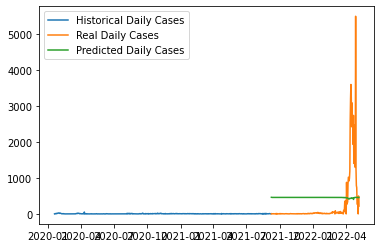

In [11]:
plt.plot(
  data.index[:len(train_set)], 
  data[:len(train_set)],
  label='Historical Daily Cases')
plt.plot(
  data.index[len(train_set):len(train_set) + len(true_cases)], 
   data[len(train_set):len(train_set) + len(true_cases)],
  label='Real Daily Cases')
plt.plot(
 data.index[len(train_set):len(train_set) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases')
 
plt.legend();

In [12]:
print( data[len(train_set):len(train_set) + len(true_cases)])
print(predicted_cases)

            confirmedIncr
dateId                   
2021-09-08              2
2021-09-09              4
2021-09-10              2
2021-09-11              3
2021-09-12              5
2021-09-13              0
2021-09-14              6
2021-09-15              4
2021-09-16              1
2021-09-17              2
2021-09-18              2
2021-09-19              4
2021-09-20              0
2021-09-21             12
2021-09-22              2
2021-09-23              9
2021-09-24              0
2021-09-25              8
2021-09-26              1
2021-09-27              0
2021-09-28              2
2021-09-29              3
2021-09-30              5
2021-10-01              9
2021-10-02              0
2021-10-03             10
2021-10-04              6
2021-10-05              4
2021-10-06              4
2021-10-07              8
...                   ...
2022-04-08           1017
2022-04-09           1015
2022-04-10            917
2022-04-11            998
2022-04-12           1190
2022-04-13  